In [140]:
import numpy as np
import pandas as pd
from numba import njit, jit

from math import log, sqrt, pi, exp, erf
from scipy.stats import norm

from matplotlib import pyplot as plt
from tqdm import tqdm
from time import perf_counter
import gc

""" API requirements """
import pandas as pd
import yfinance as yf

""" Plt font size """
plt.rcParams['font.size'] = '15'

# Question 1

------------------------------------------------------------------------------------------------------------------------
## Calculate T

In [141]:
import pandas_market_calendars as mcal
import datetime as dt
# Create a calendar
nyse = mcal.get_calendar('NYSE')

# Show available calendars
# print(mcal.get_calendar_names())
early = nyse.schedule(start_date='2022-03-07', end_date='2022-09-16')       # For fixed initial date calculator
# early = nyse.schedule(start_date=dt.datetime.now(), end_date='2022-09-16')
T = early.shape[0]

print(f'Expiration Date = {"2022-09-16"}')
print(f"Trading Days until expiration = {T} / 252") ; T = T / 252
print(f"T = {T}")
# early

Expiration Date = 2022-09-16
Trading Days until expiration = 135 / 252
T = 0.5357142857142857


## Calculate R

In [180]:
""" Treasury Bill : TMUBMUSD06M """
# t_bill = yf.Tickers(tickers="TMUBMUSD06M") #("AAPL") # NOT BEING ABLE TO GET INFORMATION FOR BILL
# t_bill.history()

r = 0.00674
R = np.log(1 + r)

print(f"r    = {r}")
print(f'CC R = {R:.5f}')

r    = 0.00674
CC R = 0.00672


## Calculate S0
### Get Historical Stock Data from Yahoo Finance

In [143]:
aapl = yf.Ticker("AAPL")

In [144]:
""" Get historical market data """
hist = aapl.history(start='2021-09-08', end='2022-03-08')
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-09-07,154.547264,156.831010,153.968844,156.262573,82278300,0.0,0
2021-09-08,156.551768,156.611602,153.559952,154.686874,74420200,0.0,0
2021-09-09,155.065844,155.684148,153.530036,153.649719,57305700,0.0,0
2021-09-10,154.577163,155.055849,148.294346,148.563614,140646400,0.0,0
2021-09-13,150.219100,151.006938,148.344223,149.142044,102404300,0.0,0
...,...,...,...,...,...,...,...
2022-03-01,164.699997,166.600006,161.970001,163.199997,83474400,0.0,0
2022-03-02,164.389999,167.360001,162.949997,166.559998,79724800,0.0,0
2022-03-03,168.470001,168.910004,165.550003,166.229996,76678400,0.0,0


### Calculate S0 from the last Closing Price - daily Interval

In [145]:
""" Closing Price - S0 """
S0 = hist.iloc[-1].Close ; print(f'S0 = {S0:.5f}')

S0 = 159.30000


## Calculate SIGMA - Historical Volatility

In [146]:
from numpy import log as ln
""" Std of the log of daily returns """
hist['prChange'] = hist.Close.pct_change()
hist['log_ret'] = np.log(1 + hist.prChange)
print("Historical Volatility the last 6 months using different methods for calculating Volatility\n")

""" Std of Log Returns for the last 6 months """
SIGMA = hist.loc[hist.index > np.datetime64('2021-09-01')].log_ret.std(ddof=1)
print(f'Std(log(returns)): \n>> {SIGMA:.9f}\n')

""" Parkinson Volatility Model """
sum_squared_log_HL = ((np.log((hist.High / hist.Low)))**2 ).loc[hist.index > np.datetime64('2021-09-01')]
parkinson_historical_volatility_last_6_months = np.sqrt( 1/(4*(sum_squared_log_HL.shape[0]-1)*np.log(2)) * sum_squared_log_HL.sum() )
print(f'Parkinson volatility: \n>> {parkinson_historical_volatility_last_6_months:.9f}\n')

""" Rogers and Satchell Volatility Function """
data = hist.loc[hist.index > np.datetime64('2021-09-01')]
daily_rs_sqr_vol = (ln(data.High/data.Open)*(ln(data.High/data.Close))) \
         + ln(data.Low/data.Open)*( ln(data.Low/data.Close))
rs_vol = np.sqrt(daily_rs_sqr_vol.mean())
print(f'Rogers and Satchell Volatility: \n>> {rs_vol:.9f}')

hist.loc[hist.index > np.datetime64('2021-09-01')].log_ret.describe()

Historical Volatility the last 6 months using different methods for calculating Volatility

Std(log(returns)): 
>> 0.016331511

Parkinson volatility: 
>> 0.014818221

Rogers and Satchell Volatility: 
>> 0.014417318


count    125.000000
mean       0.000154
std        0.016332
min       -0.040055
25%       -0.009608
50%       -0.000338
75%        0.008260
max        0.067451
Name: log_ret, dtype: float64

## Calculate K

Get available expiration dates for available options' - and find option closer to the current

In [147]:
""" Available Dates """
options_list = aapl.options
options_list

('2022-03-18',
 '2022-03-25',
 '2022-04-01',
 '2022-04-08',
 '2022-04-14',
 '2022-04-22',
 '2022-04-29',
 '2022-05-20',
 '2022-06-17',
 '2022-07-15',
 '2022-08-19',
 '2022-09-16',
 '2022-10-21',
 '2022-11-18',
 '2023-01-20',
 '2023-03-17',
 '2023-06-16',
 '2023-09-15',
 '2024-01-19',
 '2024-06-21')

In [148]:
""" Put Options ~ 6 Months from now """
opt = aapl.option_chain(options_list[ options_list == "2022-09-16"])
opt_puts = opt.puts
opt_puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL220318P00070000,2022-03-16 13:39:04+00:00,70.0,0.01,0.00,0.01,0.000000,0.000000,1.0,2461,2.875003,False,REGULAR,USD
1,AAPL220318P00075000,2022-03-08 16:33:56+00:00,75.0,0.01,0.00,0.01,0.000000,0.000000,15.0,13961,2.625003,False,REGULAR,USD
2,AAPL220318P00080000,2022-03-14 13:30:01+00:00,80.0,0.01,0.00,0.01,0.000000,0.000000,1.0,2617,2.375004,False,REGULAR,USD
3,AAPL220318P00085000,2022-03-10 14:33:05+00:00,85.0,0.01,0.00,0.01,0.000000,0.000000,1.0,2232,2.187505,False,REGULAR,USD
4,AAPL220318P00090000,2022-03-16 13:37:26+00:00,90.0,0.01,0.00,0.01,0.000000,0.000000,1001.0,6428,2.000005,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,AAPL220318P00255000,2022-02-17 15:46:12+00:00,255.0,83.75,94.80,97.05,0.000000,0.000000,NaN,0,2.693363,True,REGULAR,USD
67,AAPL220318P00265000,2022-01-31 19:19:57+00:00,265.0,91.55,97.65,98.00,0.000000,0.000000,3.0,0,0.000010,True,REGULAR,USD
68,AAPL220318P00280000,2022-03-16 19:06:13+00:00,280.0,122.55,119.90,120.95,-6.849991,-5.293656,3.0,0,2.062505,True,REGULAR,USD
69,AAPL220318P00290000,2022-03-15 13:32:15+00:00,290.0,138.35,129.30,131.65,0.000000,0.000000,1.0,0,2.507816,True,REGULAR,USD


In [149]:
""" From that list, puts ~ at the money """
_tempdf = opt_puts[opt_puts.inTheMoney == True]
option_at_the_money = _tempdf.iloc[(_tempdf['strike'] - S0 ).abs().argsort()[:1]]

K  = option_at_the_money.strike.iloc[0]
P0 = option_at_the_money.lastPrice.iloc[0]

""" Local Variables for consistency across calculations - Comment out for getting live data"""
# todo explain that we got from 7/3/2022
K  = 160.0 # EUR #
P0 = 3.15  # EUR -> Asking Price

""" Return K and P Used """
print(f"K  = {K} EUR")
print(f"P0 = {P0}  EUR <-- Asking Price for a put option with these parameters")

option_at_the_money

K  = 160.0 EUR
P0 = 3.15  EUR <-- Asking Price for a put option with these parameters


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
41,AAPL220318P00160000,2022-03-16 19:59:59+00:00,160.0,1.72,1.66,1.9,-3.76,-68.61314,10760.0,36585,0.291999,True,REGULAR,USD


# Question 2

-------------------------------------------------------------------------------------------------------------------------------
## Black Sholes Analytical Solution

In [150]:
@njit
def bs_put(S, K, T, r, sigma):
    d1 = (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    """ negative in front - negative in front of d1 """
    D = - (1.0 + erf(-d1 / sqrt(2.0))) / 2.0
    V = S*D + K*exp(-r*T)* (1.0 + erf(-d2 / sqrt(2.0))) / 2.0

    return V

In [178]:
black_sholes_put_value = bs_put(S0, K, T, R, SIGMA)
print("------ BS Put Evaluation ------")
print(f'Option Value with Black-Scholes Formula = {black_sholes_put_value:.5f}')

------ BS Put Evaluation ------
Option Value with Black-Scholes Formula = 0.82422


## Binomial Tree - Option Valuation

In [184]:
@njit
def option_valuation_bt(T, r , K, vol, N, S0 ,type="C", american=False, print_tree=False):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt)) # TODO
    d = np.exp(-vol * np.sqrt(dt)) # TODO
    p = (np.exp(r*dt) - d)/(u - d) # TODO
    """ ----- Build the Tree ----- """
    tree = np.zeros((N + 1, N + 1))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            # tree[i, j] = max(tree[i, j], S0 * d ** (i-j) * u ** (j)) # TODO
            tree[i, j] = S0 * d ** (i-j) * u ** (j) # TODO
    if print_tree: print(np.rot90(tree)) ; print()

    """ ----- Calculate the Option Value ----- """
    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward , we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        _S = tree[rows-1, c] # value in the matrix
        if type == "C": tree[rows-1, c] = max(0, _S - K) # TODO
        else: tree[rows-1, c] = max(0, K- _S) # TODO
    # print( tree.astype(int) )

    # For all other rows , we need to combine from previous rows
    # We walk backwards , from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i+1, j]
            up = tree[i + 1, j + 1]
            if type == "C":
                if american:    tree[i , j ] = max(tree[i , j ]-K, (np.exp(-r*dt)) * (p * up + (1 - p) * down)) # TODO
                else:   tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
            else:
                if american:    tree[i , j ] = max(K-tree[i , j ], (np.exp(-r*dt)) * (p * up + (1 - p) * down)) # TODO
                else:   tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
    if print_tree: print(np.rot90(tree))
    V = tree[0,0]
    """ Greeks """
    D = (tree[1, 1] - tree[1, 0])/(S0 * (u - d))
    return V

In [177]:
N = 10_000

P_bt = option_valuation_bt(T, R , K, SIGMA, N, S0, type="P")
print(f'Option Value with N({N}) steps = {P_bt:.5f}')
# print(f'Delta with N({N}) steps        = {D_bt:.5f}')

Option Value with N(10000) steps = 0.82423


## Calculate/Plot Option Value Convergence with N (steps)

In [154]:
NN = 10_000 ;   size = 100
values = np.zeros((size, 3))
for n in tqdm(np.append(np.logspace(1, np.log10(NN), size, base=10, dtype=int), 50)): #  _starting_n, NN)):
    # print(n)
    _st = perf_counter()
    P_bt = option_valuation_bt(T, R , K, SIGMA, n, S0, type="P")
    values[size-1] = [n, P_bt, perf_counter() - _st]
    size -= 1
values = values[::-1]

100%|██████████| 101/101 [00:05<00:00, 18.54it/s]


,Binary Tree,Execution Time,Black Scholes,|Difference|
10,0.838516,0.000006,0.824223,0.014293
11,0.816563,0.000004,0.824223,0.007660
12,0.834590,0.000005,0.824223,0.010366
13,0.822259,0.000004,0.824223,0.001964
14,0.831305,0.000007,0.824223,0.007082
...,...,...,...,...
7564,0.824203,0.355288,0.824223,0.000021
8111,0.824198,0.430975,0.824223,0.000025
8697,0.824239,0.739488,0.824223,0.000015
9326,0.824232,0.708561,0.824223,0.000009


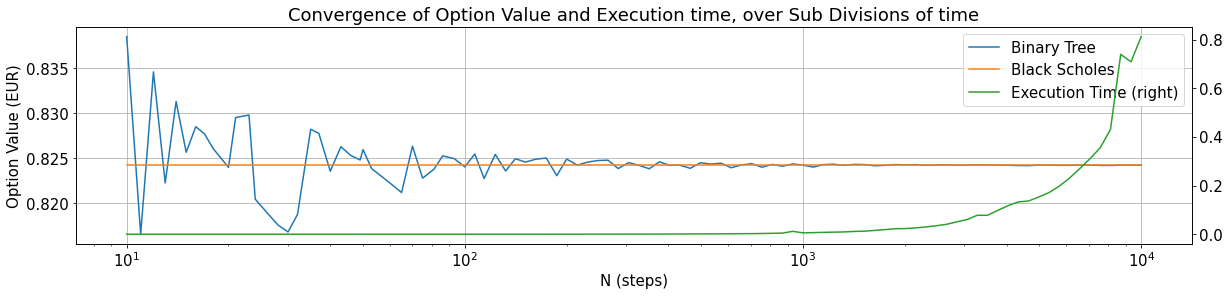

In [155]:
plt.rcParams['font.size'] = '15'
_results_convergence_df = pd.DataFrame(values[:, 1:], columns=['Binary Tree', 'Execution Time'] , index=values[:, 0].astype(int)).sort_index()
_results_convergence_df["Black Scholes"] = black_sholes_put_value
_results_convergence_df["|Difference|"] = abs(_results_convergence_df[['Binary Tree']] - black_sholes_put_value)

_results_convergence_df[['Binary Tree', 'Black Scholes', 'Execution Time']].plot(figsize=(20,4), xlabel='N (steps)', ylabel='Option Value (EUR)', mark_right=True,
                              title='Convergence of Option Value and Execution time, over Sub Divisions of time', grid=True, logx=True,
                              secondary_y='Execution Time' )
_results_convergence_df

# Question 3

----------------------------------------------------------------------------------------------------------------

## (a) Print 3 step Binomial Tree - American and European

In [185]:
N = 3
print(" American 3-step Binomial Tree")
va = option_valuation_bt(T, r , K, SIGMA, N, S0, type="P", american=True,  print_tree=True)

print("\n European 3-step Binomial Tree")
ve = option_valuation_bt(T, r , K, SIGMA, N, S0, type="P", american=False, print_tree=True)

 American 3-step Binomial Tree
[[  0.           0.           0.         162.63252461]
 [  0.           0.         161.51400907 160.40318618]
 [  0.         160.40318618 159.30000305 158.20440713]
 [159.30000305 158.20440713 157.11634625 156.03576857]]

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.3077223  0.74333302 1.79559287]
 [0.92329542 1.79559287 2.88365375 3.96423143]]

 European 3-step Binomial Tree
[[  0.           0.           0.         162.63252461]
 [  0.           0.         161.51400907 160.40318618]
 [  0.         160.40318618 159.30000305 158.20440713]
 [159.30000305 158.20440713 157.11634625 156.03576857]]

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.3077223  0.74333302 1.79559287]
 [0.82113275 1.54880905 2.69119816 3.96423143]]


## (a) Plot Relative to Time - American vs European

In [157]:
N = 1_000   ;   size = 100  ;   values = np.zeros((size, 3))
for _T in tqdm(np.linspace(1/252, 3, num=size)):
    _P_bt_european = option_valuation_bt(_T, R, S0, SIGMA, N, S0, type="P")
    _P_bt_american = option_valuation_bt(_T, R, S0, SIGMA, N, S0, type="P", american=True)
    values[size-1] = [_T, _P_bt_european, _P_bt_american]
    size -= 1
values = values[::-1]
values

100%|██████████| 100/100 [00:01<00:00, 73.18it/s]


array([[0.00396825, 0.06326264, 0.06350347],
       [0.0342312 , 0.17419991, 0.17683763],
       [0.06449415, 0.23039334, 0.23573687],
       [0.09475709, 0.27118209, 0.27938003],
       [0.12502004, 0.30374237, 0.31489239],
       [0.15528299, 0.3309924 , 0.34516514],
       [0.18554594, 0.35446132, 0.37171061],
       [0.21580888, 0.37506831, 0.39543643],
       [0.24607183, 0.39341647, 0.41693783],
       [0.27633478, 0.40992658, 0.43662888],
       [0.30659772, 0.42490578, 0.45481191],
       [0.33686067, 0.4385863 , 0.4717151 ],
       [0.36712362, 0.45114867, 0.48751582],
       [0.39738656, 0.46273647, 0.50235493],
       [0.42764951, 0.47346607, 0.51634651],
       [0.45791246, 0.48343328, 0.5295842 ],
       [0.4881754 , 0.49271811, 0.5421464 ],
       [0.51843835, 0.50138814, 0.55409918],
       [0.5487013 , 0.50950105, 0.5654986 ],
       [0.57896425, 0.51710654, 0.57639369],
       [0.60922719, 0.52424776, 0.58682621],
       [0.63949014, 0.53096245, 0.59683324],
       [0.

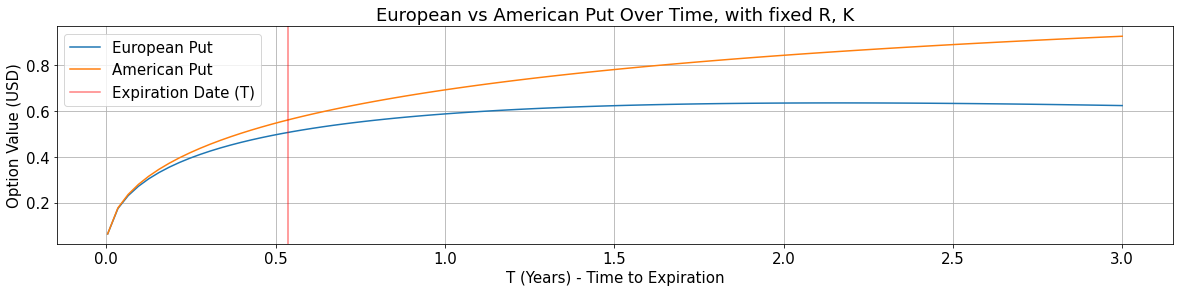

In [158]:
_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()
_results_df

axs = _results_df[['European Put', 'American Put']].plot(figsize=(20,4), xlabel='T (Years) - Time to Expiration', ylabel='Option Value (USD)',
                              title='European vs American Put Over Time, with fixed R, K', grid=True)
axs.axvline(T, color='r', linestyle='-', alpha=.5, label='Expiration Date (T)') ;   axs.legend()

## (b) Plot Option Value Relative to N - American vs European

In [159]:
size = 200  ;   values = np.zeros((size, 3))
for n in tqdm(np.logspace(1, 4, num=size, base=10, dtype=int)):
    _P_bt_european = option_valuation_bt(T, R , K, SIGMA, n, S0, type="P")
    _P_bt_american = option_valuation_bt(T, R , K, SIGMA, n, S0, type="P", american=True)
    values[size-1] = [n, _P_bt_european, _P_bt_american]
    size -= 1
values = values[::-1]
values

100%|██████████| 200/200 [00:21<00:00,  9.35it/s]  


array([[1.00000000e+01, 8.38516395e-01, 9.40016892e-01],
       [1.00000000e+01, 8.38516395e-01, 9.40016892e-01],
       [1.00000000e+01, 8.38516395e-01, 9.40016892e-01],
       [1.10000000e+01, 8.16563453e-01, 9.33602936e-01],
       [1.10000000e+01, 8.16563453e-01, 9.33602936e-01],
       [1.10000000e+01, 8.16563453e-01, 9.33602936e-01],
       [1.20000000e+01, 8.34589566e-01, 9.37976325e-01],
       [1.20000000e+01, 8.34589566e-01, 9.37976325e-01],
       [1.30000000e+01, 8.22259393e-01, 9.35827517e-01],
       [1.30000000e+01, 8.22259393e-01, 9.35827517e-01],
       [1.40000000e+01, 8.31305295e-01, 9.35552502e-01],
       [1.40000000e+01, 8.31305295e-01, 9.35552502e-01],
       [1.50000000e+01, 8.25658139e-01, 9.35977310e-01],
       [1.50000000e+01, 8.25658139e-01, 9.35977310e-01],
       [1.60000000e+01, 8.28510970e-01, 9.32911600e-01],
       [1.60000000e+01, 8.28510970e-01, 9.32911600e-01],
       [1.70000000e+01, 8.27695743e-01, 9.35818321e-01],
       [1.80000000e+01, 8.26097

European Put    0.824235
American Put    0.932587
Difference      0.108353
Name: 10000.0, dtype: float64

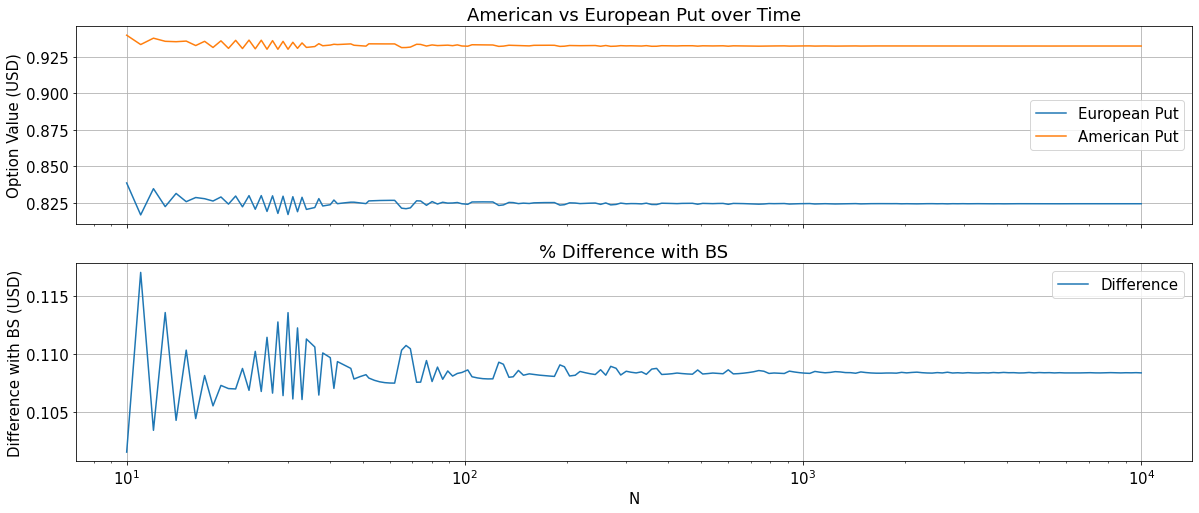

In [160]:
_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()
_results_df["Difference"] = _results_df[['American Put']].to_numpy() - _results_df[['European Put']].to_numpy()

fig, axs = plt.subplots(2, sharex=True)

_results_df[['European Put', 'American Put']].plot(figsize=(20,8), xlabel='N', ylabel='Option Value (USD)', ax=axs[0],
                              title='American vs European Put over Time', grid=True, logx=True)
_results_df[["Difference"]].plot(figsize=(20,8), xlabel='N', ylabel='Difference with BS (USD)',  ax=axs[1],
                              title='% Difference with BS', grid=True, logx=True)
_results_df.iloc[-1]

## (b) Difference in value between European and American Puts

In [161]:
N = 20_000
european = option_valuation_bt(T, r , K, SIGMA, N, S0, type="P")
american = option_valuation_bt(T, r , K, SIGMA, N, S0, type="P", american=True)

print(f'European Put Value = {european:.5f} USD')
print(f'American Put Value = {american:.5f} USD')
print(f'Difference = {american - european:.5f} USD or {(american - european)/american * 100:.2f} %')

European Put Value = 0.82320 USD
American Put Value = 0.93201 USD
Difference = 0.10881 USD or 11.67 %


## (c) Effect of Interest Rates to American and European Puts

In [162]:
N = 100
size = 100  ;   values = np.zeros((size, 3))
for _r in tqdm(np.linspace(-2, 5, num=size)): #  _starting_n, NN)):
    _r = np.log(1+ _r/100) # From annual to CCIR
    _V_bt_european = option_valuation_bt(T, _r , K, SIGMA, N, S0, type="P")
    _V_bt_american = option_valuation_bt(T, _r , K, SIGMA, N, S0, type="P", american=True)
    values[size-1] = [_r, _V_bt_european, _V_bt_american]
    size -= 1
values = values[::-1]
# values[1:] = np.maximum(values[1:], 0.)
values

100%|██████████| 100/100 [00:00<00:00, 7717.64it/s]


array([[-2.02027073e-02,  2.53330033e+00,  2.53330033e+00],
       [-1.94814668e-02,  2.47731050e+00,  2.47731050e+00],
       [-1.87607460e-02,  2.42175415e+00,  2.42175415e+00],
       [-1.80405443e-02,  2.36664491e+00,  2.36664491e+00],
       [-1.73208609e-02,  2.31199653e+00,  2.31199653e+00],
       [-1.66016951e-02,  2.25782279e+00,  2.25782279e+00],
       [-1.58830462e-02,  2.20413755e+00,  2.20413755e+00],
       [-1.51649133e-02,  2.15095467e+00,  2.15095467e+00],
       [-1.44472957e-02,  2.09828801e+00,  2.09828801e+00],
       [-1.37301928e-02,  2.04615138e+00,  2.04615138e+00],
       [-1.30136037e-02,  1.99455853e+00,  1.99455853e+00],
       [-1.22975278e-02,  1.94352312e+00,  1.94352312e+00],
       [-1.15819643e-02,  1.89305865e+00,  1.89305865e+00],
       [-1.08669124e-02,  1.84317849e+00,  1.84317849e+00],
       [-1.01523715e-02,  1.79389581e+00,  1.79389581e+00],
       [-9.43834073e-03,  1.74522355e+00,  1.74522355e+00],
       [-8.72481947e-03,  1.69717440e+00

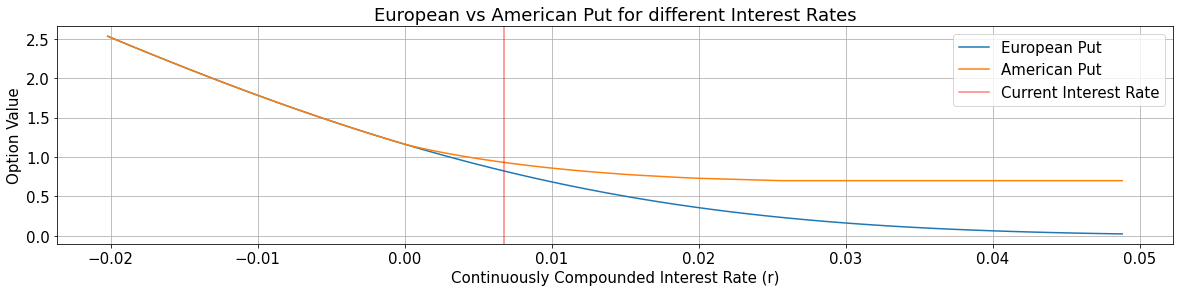

In [163]:
_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()

""" Plot """
axs = _results_df[['European Put', 'American Put']].plot(figsize=(20,4), xlabel='Continuously Compounded Interest Rate (r)', ylabel='Option Value',title='European vs American Put for different Interest Rates', grid=True)
axs.axvline(r, color='r', linestyle='-', alpha=.5, label='Current Interest Rate') ;   axs.legend()


## (c) Calculate Expected Difference with European Put Using Analytical Solution for European Put

In [164]:
def calculate_SE():
    size = 11   ;   _N = 2_000
    _results_se = np.empty((size, 3))  ;   index = 0
    for _coef in np.linspace(-1, 1, num=size):
        _sigma = SIGMA * (10**_coef)
        _results_se[index, 0] = _sigma
        _results_se[index, 1] = _coef
        _results_se[index, 2] = (option_valuation_bt(T, R, K, _sigma, _N, S0, type="P", american=True) -
                                 bs_put(S0, K, T, R, _sigma)) / bs_put(S0, K, T, R, _sigma) * 100
        index += 1
    return _results_se
_results_se = calculate_SE()
_results_se

array([[ 1.63315113e-03, -1.00000000e+00,  3.53117296e+02],
       [ 2.58837011e-03, -8.00000000e-01,  2.62143970e+02],
       [ 4.10229017e-03, -6.00000000e-01,  1.69205065e+02],
       [ 6.50169176e-03, -4.00000000e-01,  8.95523695e+01],
       [ 1.03044870e-02, -2.00000000e-01,  3.28014680e+01],
       [ 1.63315113e-02,  0.00000000e+00,  1.31489999e+01],
       [ 2.58837011e-02,  2.00000000e-01,  6.07935327e+00],
       [ 4.10229017e-02,  4.00000000e-01,  3.05291771e+00],
       [ 6.50169176e-02,  6.00000000e-01,  1.60683018e+00],
       [ 1.03044870e-01,  8.00000000e-01,  8.96260394e-01],
       [ 1.63315113e-01,  1.00000000e+00,  5.09545554e-01]])

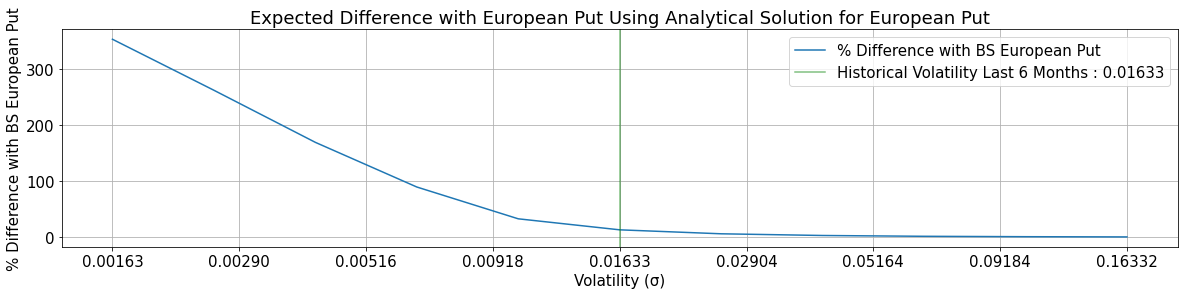

In [165]:
_results_se_df = pd.DataFrame(_results_se[:, 1:], columns=['Volatility (σ)','% Difference with BS European Put'])
_results_se_df.set_index("Volatility (σ)", inplace=True)

ax = _results_se_df.plot(figsize=(20,4), grid=True, ylabel='% Difference with BS European Put', title="Expected Difference with European Put Using Analytical Solution for European Put")
ax.axvline(0, color='g', linestyle='-', alpha=.5, label=f'Historical Volatility Last 6 Months : {SIGMA:.5f}')   ;   ax.legend()

plt.xticks(plt.xticks()[0][1:-1], [f'{SIGMA * (10**x):.5f}' for x in plt.xticks()[0][1:-1]])    ;   print()

# 3D Graphs -> Visualize the relationship between a Put Option's Value (P) and the Strike Price (K) and Volatility (SIGMA)

In [166]:
import multiprocessing
from joblib import Parallel, delayed
gc.collect()

""" Simulation Parameters """
N = 2_000    ;    total_points = 900  ;    print(f'Total Steps Calculated (N) = {N*total_points}') # points should be [2500, 900]

start_sigma = 0.001  ;   end_sigma = .2 # * realized_volatility_last_6_months
start_K = 0.8 * S0  ;   end_K = 1.2 * S0

""" Prepare Input """
size_of_graph = np.sqrt(total_points).astype(int)   # points should be [2500, 900]
V_values = np.logspace(np.log10(start_sigma), np.log10(end_sigma), size_of_graph, base=10)
# V_values = np.linspace(start_sigma, end_sigma, size_of_graph)
K_values = np.linspace(start_K, end_K, size_of_graph, dtype=int)

input_matrix = np.empty((0, 2))
for _sigma in V_values:
    for _K in K_values:
        input_matrix = np.append(input_matrix, np.array([[_sigma, _K]]), axis=0)

inputs = tqdm(input_matrix)

""" Define function that calculates """
def simulate(input_matrix):
    v = option_valuation_bt(T=.53, r=0.006 , K=input_matrix[1], vol=input_matrix[0], N=N, S0=S0 ,type="P", american=True)
    return np.array([np.log10(input_matrix[0]), input_matrix[1], v])
    # return np.array([input_matrix[0], input_matrix[1], v])

""" Run Parallel Simulation """
num_cores = multiprocessing.cpu_count()
temp_output = Parallel(n_jobs=num_cores)(delayed(simulate)(row) for row in inputs)
""" Revert back to matrix form"""
# print(temp_output)
result_3D = np.empty((0, 3))
for array in temp_output:
    result_3D = np.append(result_3D, [array], axis=0)
result_3D

Total Steps Calculated (N) = 1800000


100%|██████████| 900/900 [00:09<00:00, 99.41it/s] 


array([[ -3.        , 127.        ,   0.        ],
       [ -3.        , 129.        ,   0.        ],
       [ -3.        , 131.        ,   0.        ],
       ...,
       [ -0.69897   , 186.        ,  28.18401248],
       [ -0.69897   , 188.        ,  29.94488647],
       [ -0.69897   , 191.        ,  32.63982596]])

159.3000030517578

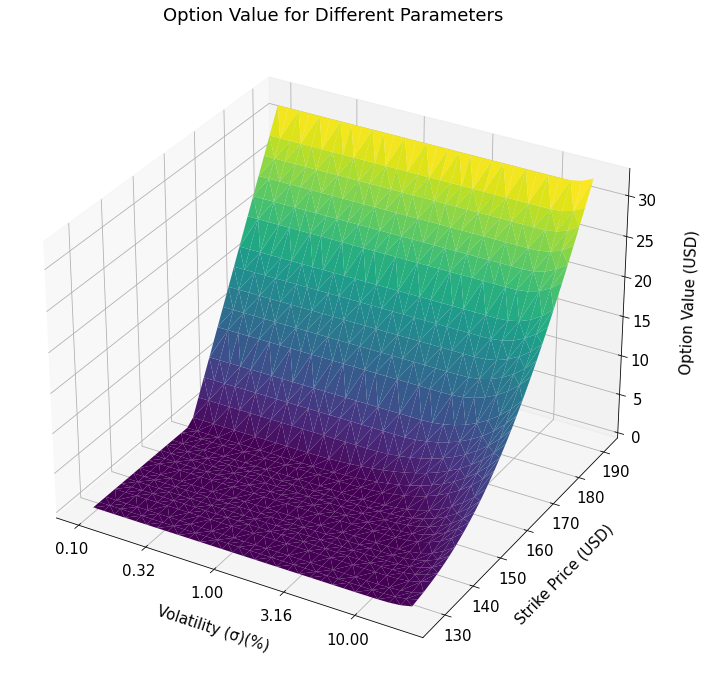

In [167]:
plt.rcParams['font.size'] = '15'

fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')
ax.plot_trisurf(result_3D[:, 0], result_3D[:, 1], result_3D[:, 2], cmap='viridis', edgecolor='none')  # 'viridis' , cm.jet

plt.xticks(plt.xticks()[0][1:-1], [f'{10**x*100:.2f}' for x in plt.xticks()[0][1:-1]])

ax.set_ylabel('\n\nStrike Price (USD)')   ;   ax.set_xlabel('\n\nVolatility (σ)(%)')   ;   ax.set_zlabel('\n\n\nOption Value (USD)')
ax.dist = 10
ax.set_title("Option Value for Different Parameters")
S0

In [168]:
import multiprocessing
from joblib import Parallel, delayed
gc.collect()

""" Simulation Parameters """
N = 2_000    ;    total_points = 900  ;    print(f'Total Steps Calculated (N) = {N*total_points}') # points should be [2500, 900]

start_sigma = 0.001  ;   end_sigma = .2 # * realized_volatility_last_6_months
start_T = 1/253 ;   end_T = 3

""" Prepare Input """
size_of_graph = np.sqrt(total_points).astype(int)   # points should be [2500, 900]
V_values = np.logspace(np.log10(start_sigma), np.log10(end_sigma), size_of_graph, base=10)
# V_values = np.linspace(start_sigma, end_sigma, size_of_graph)
T_values = np.linspace(start_T, end_T, size_of_graph, dtype=int)

input_matrix = np.empty((0, 2))
for _sigma in V_values:
    for _T in T_values:
        input_matrix = np.append(input_matrix, np.array([[_sigma, _T]]), axis=0)

inputs = tqdm(input_matrix)

""" Define function that calculates """
def simulate(input_matrix):
    v = option_valuation_bt(T=_T, r=0.006 , K=K, vol=input_matrix[0], N=N, S0=S0 ,type="P", american=True)
    return np.array([np.log10(input_matrix[0]), input_matrix[1], v])
    # return np.array([input_matrix[0], input_matrix[1], v])

""" Run Parallel Simulation """
num_cores = multiprocessing.cpu_count()
temp_output = Parallel(n_jobs=num_cores)(delayed(simulate)(row) for row in inputs)  ;   gc.collect()

""" Revert back to matrix form"""
result_3D = np.empty((0, 3))
for array in temp_output:
    result_3D = np.append(result_3D, [array], axis=0)
result_3D

Total Steps Calculated (N) = 1800000


100%|██████████| 900/900 [00:05<00:00, 159.36it/s]


array([[-3.        ,  0.        ,  0.69999695],
       [-3.        ,  0.        ,  0.69999695],
       [-3.        ,  0.        ,  0.69999695],
       ...,
       [-0.69897   ,  2.        , 20.9459724 ],
       [-0.69897   ,  2.        , 20.9459724 ],
       [-0.69897   ,  3.        , 20.9459724 ]])

Text(0.5, 0.92, 'Option Value for Different Parameters')

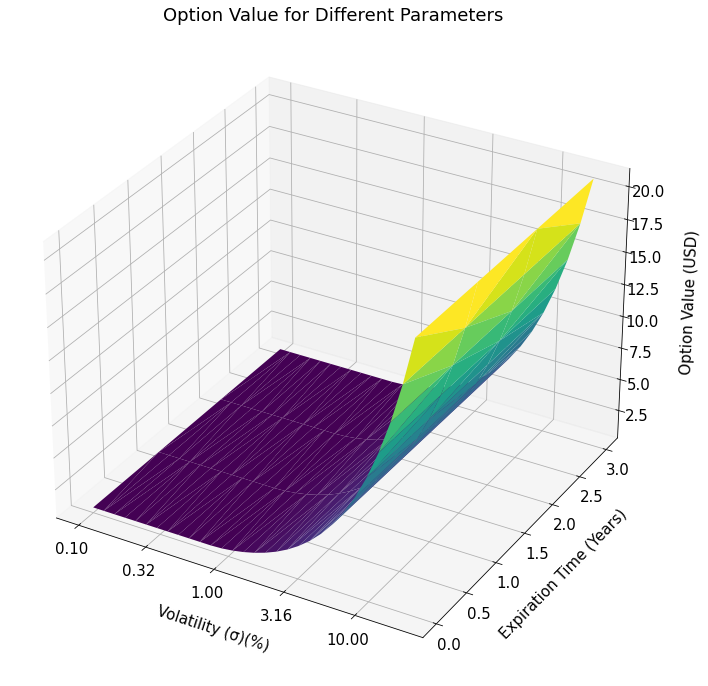

In [169]:
plt.rcParams['font.size'] = '15'

fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')
ax.plot_trisurf(result_3D[:, 0], result_3D[:, 1], result_3D[:, 2], cmap='viridis', edgecolor='none')  # 'viridis' , cm.jet

plt.xticks(plt.xticks()[0][1:-1], [f'{10**x*100:.2f}' for x in plt.xticks()[0][1:-1]])

ax.set_ylabel('\n\nExpiration Time (Years)')   ;   ax.set_xlabel('\n\nVolatility (σ)(%)')   ;   ax.set_zlabel('\n\n\nOption Value (USD)')
ax.dist = 10
ax.set_title("Option Value for Different Parameters")

# Question 4

---------------------------------------------------------------------------------------------------------------------------------
## Calculate Implied Volatility
Using the bump-and-revalue, gradient algorithm

In [170]:
""" Choice Number of Steps """
print('-------- Number of steps --------')
print(_results_convergence_df[_results_convergence_df.index > 1000].index.values)

-------- Number of steps --------
[ 1072  1149  1232  1321  1417  1519  1629  1747  1873  2009  2154  2310
  2477  2656  2848  3053  3274  3511  3764  4037  4328  4641  4977  5336
  5722  6135  6579  7054  7564  8111  8697  9326 10000]


In [171]:
N = 5336
Approximation_Error = _results_convergence_df[_results_convergence_df.index == N][["|Difference|"]].values[0,0]
Approximation_Error

2.5085137509983646e-05

In [187]:
epsilon = 0.0001
s0 = SIGMA
print(f"Correct Option Value = {P0}")

_P0 = option_valuation_bt(T, r, K, s0, N, S0, type="P", american=True)  ;   runs = 0    ;   _iv_convergence = [s0]
print(f"_P0 = {_P0}")
print(f"difference in P0 estimation = {_P0 - P0}")

_st = perf_counter()
while True:
    runs += 1  # ; print("|", end="")
    """ step 1: calculate new Option Values """
    _Pt = option_valuation_bt(T, r, K, s0+epsilon, N, S0, type="P", american=True)
    print(f'Pt = {_Pt}')

    """ step 2: Calculate new delta between them """
    _D =  _P0 - _Pt  # if _P0 is larger that _Pt, delta has to be positive
    print(f'_D = {_D}')

    """ step 3: Estimate correct Delta """
    _Dc = P0 - _Pt  # if P0 is larger than _Pt, the delta_correct has to bo be positive
    print(f'_Dc = {_Dc}')

    """ step 4: Estimate new s0 based on Deltas' Ratio """
    s0 += - (_Dc / _D * epsilon)  # Adjusting the rate of change for
    _iv_convergence.append(s0)
    print(f's0 = {s0}')

    """ step 5: Calculate if the approximation is within the SE """
    _P0 = option_valuation_bt(T, r, K, s0, N, S0, type="P", american=True)
    print(f"_P0 = {_P0}")

    print(f">>> Difference in P0 estimation = {_P0 - P0} \n\n")
    if abs(_P0 - P0) < Approximation_Error : break
    epsilon /= 10

print(f"Time to Calculate = {perf_counter() - _st:.7f}")
IV = s0

Correct Option Value = 3.15
_P0 = 0.9232954167223871
difference in P0 estimation = -2.2267045832776127
Pt = 0.9280126817112122
_D = -0.004717264988825076
_Dc = 2.2219873182887877
s0 = 0.06343480789439135
_P0 = 3.2931475231750493
>>> Difference in P0 estimation = 0.14314752317504942 


Pt = 3.293655949955844
_D = -0.0005084267807946574
_Dc = -0.14365594995584408
s0 = 0.060609308621294176
_P0 = 3.1494455998995954
>>> Difference in P0 estimation = -0.0005544001004045285 


Pt = 3.1494964757595016
_D = -5.087585990626309e-05
_Dc = 0.0005035242404982654
s0 = 0.06061920573637834
_P0 = 3.149949123589933
>>> Difference in P0 estimation = -5.087641006706889e-05 


Pt = 3.1499542111641228
_D = -5.087574189932553e-06
_Dc = 4.5788835877136336e-05
s0 = 0.06062010574951167
_P0 = 3.1499949124213056
>>> Difference in P0 estimation = -5.087578694329409e-06 


0.0003551250556483865


In [173]:
print(f'Implied Volatility = {IV:.5f}  vs  '
      f'Historical Volatility = {SIGMA:.5f}  :  '
      f'Difference = {(IV - SIGMA)/SIGMA * 100 :.3f} %  \n'
      f'>>> Iterations = {runs}')

Implied Volatility = 0.06529  vs  Historical Volatility = 0.01633  :  Difference = 299.795 %  
>>> Iterations = 4


In [174]:
""" History which the Algorithm converges to the implied volatility """
_iv_convergence

[0.016331511311465756,
 0.07085229852277239,
 0.0652832691385099,
 0.06529161071101816,
 0.06529251070870531]